In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

### Loading Training data from the CSV file

In [3]:
df = pd.read_csv('../data/raw/beer_reviews.csv')

### Showing the imported data

In [5]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


### Checking data types

In [6]:
df.dtypes

brewery_id              int64
brewery_name           object
review_time             int64
review_overall        float64
review_aroma          float64
review_appearance     float64
review_profilename     object
beer_style             object
review_palate         float64
review_taste          float64
beer_name              object
beer_abv              float64
beer_beerid             int64
dtype: object

### Evaluating the quality of data

In [7]:
from src.data.explore import print_na_info, missing_values_table

missing_values_table(df)

Your selected dataframe has 13 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
beer_abv,67785,4.3
review_profilename,348,0.0
brewery_name,15,0.0


In [8]:
print_na_info(df)

,feature,null_value_count,null_value_percent
0,beer_abv,67785,4.272306
1,review_profilename,348,0.021934
2,brewery_name,15,0.000945


### Removing unwanted columns including ID column, resetting indexes and writing data to a file

In [9]:
df_cleaned = df.copy()
df_cleaned.drop(['brewery_id', 'review_time', 'review_overall', 'review_profilename', 'beer_name', 'beer_beerid'], axis=1, inplace=True) # Dropping unwanted columns
df_cleaned.dropna(inplace=True) # Remove missing values
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned.to_csv('../data/interim/beer_reviews.csv', index=False) # Saving intermediate date to a file

### Normalising numeric and categorical columns. Saving standard scaler and categorical value order for API to reuse to normalise the requests.

In [10]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from joblib import dump, load # To save the standard scaler

# Normalising numerical values
num_cols = ['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv']
sc = StandardScaler()
X_train_cleaned = df_cleaned.copy()
X_train_cleaned[num_cols] = sc.fit_transform(X_train_cleaned[num_cols])
dump(sc, '../data/processed/std_scaler.bin', compress=True) # Saving standard scaler to use in API

# Converting categorical values to numeric and saving the categories
cat_cols = ['brewery_name']
oe_cat = OrdinalEncoder()
X_train_cleaned[cat_cols] = oe_cat.fit_transform(X_train_cleaned[cat_cols])
brewery_names = oe_cat.categories_[0]
np.save('../data/processed/brewery_names.npy', brewery_names) # Saving unique name array to use in API

# Convert target values to numeric and saving them
target_col = ['beer_style']
oe_target = OrdinalEncoder()
X_train_cleaned[target_col] = oe_target.fit_transform(X_train_cleaned[target_col])
beer_style_names = oe_target.categories_[0]
np.save('../data/processed/beer_style_names.npy', beer_style_names) # Saving unique array to use in API

X_train_cleaned.reset_index(drop=True, inplace=True)

### Check normalised data

In [11]:
X_train_cleaned.head()

,brewery_name,review_aroma,review_appearance,beer_style,review_palate,review_taste,beer_abv
0,4886.0,-2.511041,-2.198046,65.0,-3.317269,-3.161958,-0.879384
1,4886.0,-1.792025,-1.384166,51.0,-1.109371,-1.103408,-0.362706
2,4886.0,-1.792025,-1.384166,59.0,-1.109371,-1.103408,-0.233537
3,4886.0,-1.073010,-0.570285,61.0,-1.845337,-1.103408,-0.879384
4,1360.0,1.084037,0.243595,9.0,0.362561,0.955143,0.283141


In [12]:
X_train_cleaned.describe()

,brewery_name,review_aroma,review_appearance,beer_style,review_palate,review_taste,beer_abv
count,1.518814e+06,1.518814e+06,1.518814e+06,1.518814e+06,1.518814e+06,1.518814e+06,1.518814e+06
mean,2.619459e+03,1.109312e-16,3.026282e-16,4.221748e+01,2.271770e-16,5.688781e-17,2.230601e-17
std,1.557927e+03,1.000000e+00,1.000000e+00,3.303752e+01,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000e+00,-3.949072e+00,-6.267448e+00,0.000000e+00,-4.053235e+00,-3.848142e+00,-3.027902e+00
25%,1.216000e+03,-3.539941e-01,-5.702854e-01,1.200000e+01,-3.734048e-01,-4.172240e-01,-7.932707e-01
50%,2.545000e+03,3.650216e-01,2.435949e-01,3.100000e+01,3.625612e-01,2.689595e-01,-2.335365e-01
75%,4.136000e+03,3.650216e-01,2.435949e-01,7.400000e+01,3.625612e-01,9.551430e-01,6.275930e-01
max,5.154000e+03,1.803053e+00,1.871356e+00,1.030000e+02,1.834493e+00,1.641327e+00,2.181138e+01


### Creating a dataframe with both features and target

In [13]:
X = X_train_cleaned[num_cols+cat_cols+target_col]

In [14]:
X.shape

(1518814, 7)

In [15]:
X.head()

,review_aroma,review_appearance,review_palate,review_taste,beer_abv,brewery_name,beer_style
0,-2.511041,-2.198046,-3.317269,-3.161958,-0.879384,4886.0,65.0
1,-1.792025,-1.384166,-1.109371,-1.103408,-0.362706,4886.0,51.0
2,-1.792025,-1.384166,-1.109371,-1.103408,-0.233537,4886.0,59.0
3,-1.073010,-0.570285,-1.845337,-1.103408,-0.879384,4886.0,61.0
4,1.084037,0.243595,0.362561,0.955143,0.283141,1360.0,9.0


### Visualising the target distribution

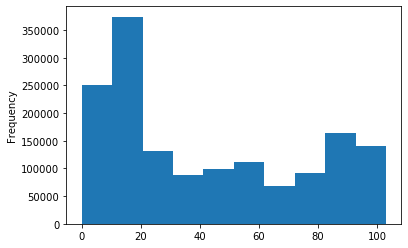

In [16]:
X_train_cleaned['beer_style'].value_counts()/len(X_train_cleaned)
X_train_cleaned['beer_style'].astype(int).plot.hist()

### Visualizing corelation

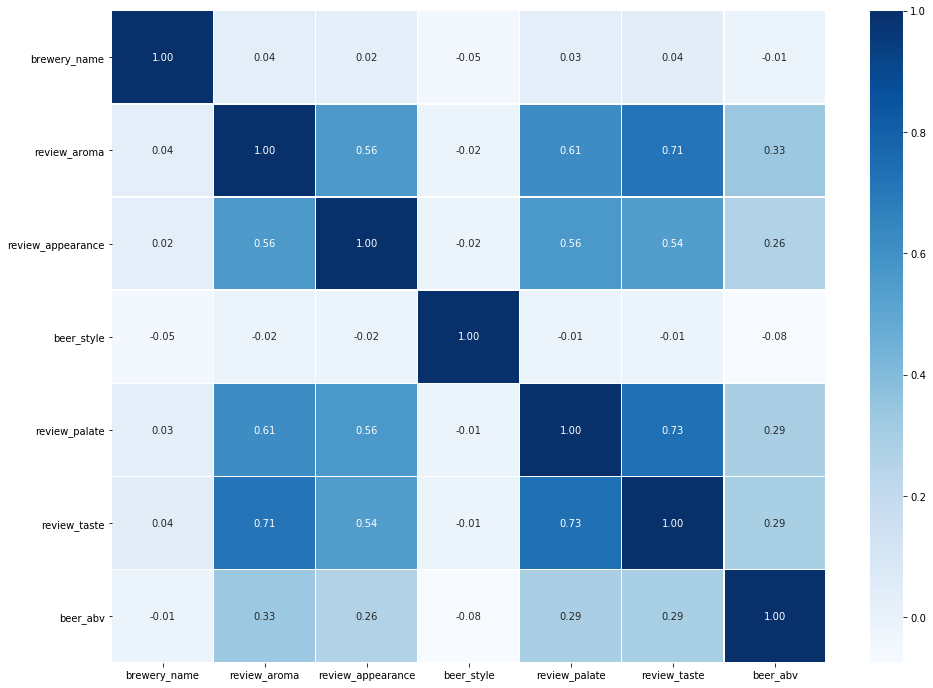

Most Positive Correlations with Target:
beer_abv            -0.075147
brewery_name        -0.053696
review_aroma        -0.015717
review_appearance   -0.015088
review_taste        -0.013458
review_palate       -0.012803
beer_style           1.000000
Name: beer_style, dtype: float64

Most Negative Correlations with Target:
beer_abv            -0.075147
brewery_name        -0.053696
review_aroma        -0.015717
review_appearance   -0.015088
review_taste        -0.013458
review_palate       -0.012803
beer_style           1.000000
Name: beer_style, dtype: float64


In [17]:
from src.visualization.visualize import corrs_graph, corrs_X_y, plot_two_series

corrs_graph(X_train_cleaned)
corrs_X_y(X_train_cleaned, 'beer_style')

### Importing developed modules

In [18]:
import torch
from importlib.machinery import SourceFileLoader # Loading source file using this since serialised torch model require the class definition.
sets = SourceFileLoader('sets', '../src/data/sets.py').load_module()
null = SourceFileLoader('null', '../src/models/null.py').load_module()


### Splitting dataset and converting them to tensors

In [20]:
py_torch = SourceFileLoader('pytorch', '../src/models/pytorch.py').load_module()
X_train, y_train, X_val, y_val, X_test, y_test = sets.split_sets_by_time(X, target_col='beer_style', test_ratio=0.2)

train_dataset = py_torch.PytorchDataset(X_train, y_train)
test_dataset = py_torch.PytorchDataset(X_test, y_test)
valid_dataset = py_torch.PytorchDataset(X_val, y_val)

### Check the shape of the training data. 

In [21]:
X_train.shape

(911290, 6)

In [22]:
y_train.shape

(911290,)

### Calculating the number of classes

In [24]:
num_classes = len(beer_style_names)
num_classes

104

### Number of input features

In [25]:
input_feature_count = X_train.shape[1]
input_feature_count

6

### Train the NN model

In [55]:
import torch
import torch.nn as nn
py_torch = SourceFileLoader('pytorch', '../src/models/pytorch.py').load_module()

train_losses=[]
train_accu=[]
val_losses=[]
val_accu=[]

learning_rate = 0.001
N_EPOCHS = 7119
BATCH_SIZE = 128

model = py_torch.PytorchMultiClass(input_feature_count, num_classes)
device = py_torch.get_device()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(N_EPOCHS):
    train_loss, train_acc = py_torch.train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
    valid_loss, valid_acc = py_torch.test_classification(valid_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)
    
    if epoch%5==0:
        print(f'Epoch: {epoch}')
        print(f'\t(train)\t|\tLoss: {train_loss}\t|\tAcc: {train_acc}%')
        print(f'\t(valid)\t|\tLoss: {valid_loss}\t|\tAcc: {valid_acc}%')
    train_losses.append(train_loss)
    train_accu.append(train_acc)
    val_losses.append(valid_loss)
    val_accu.append(valid_acc)

PytorchMultiClass v12
Epoch: 0
	(train)	|	Loss: 0.0359	|	Acc: 7.04%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 5
	(train)	|	Loss: 0.0358	|	Acc: 8.44%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 10
	(train)	|	Loss: 0.0358	|	Acc: 8.44%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 15
	(train)	|	Loss: 0.0358	|	Acc: 8.44%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 20
	(train)	|	Loss: 0.0358	|	Acc: 8.45%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 25
	(train)	|	Loss: 0.0358	|	Acc: 8.44%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 30
	(train)	|	Loss: 0.0358	|	Acc: 8.42%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 35
	(train)	|	Loss: 0.0358	|	Acc: 8.44%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 40
	(train)	|	Loss: 0.0358	|	Acc: 8.45%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 45
	(train)	|	Loss: 0.0358	|	Acc: 8.45%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 50
	(train)	|	Loss: 0.0358	|	Acc: 8.45%
	(valid)	|	Loss: 0.0359	|	Acc: 6.4%
Epoch: 55
	(train)	|	Loss: 0.0358	|	Acc: 8.45%
	(valid)	|	Loss: 0.0

KeyboardInterrupt: 

### Plotting losses and accuracy

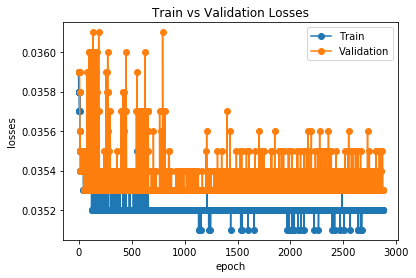

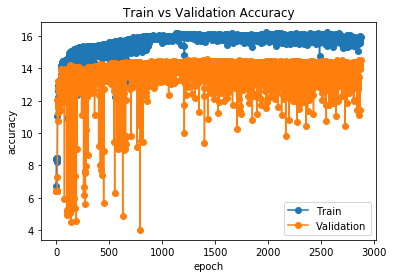

In [33]:
plot_two_series(train_losses, val_losses, 'epoch', 'losses', ['Train','Validation'], 'Train vs Validation Losses')
plot_two_series(train_accu, val_accu, 'epoch', 'accuracy', ['Train','Validation'], 'Train vs Validation Accuracy')

### Saving the model

In [34]:
torch.save(model, "../models/pytorch_classification_v3.pt")

In [56]:
test_loss, test_acc = py_torch.test_classification(test_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)
print(f'\t(Test)\t|\tLoss: {test_loss}\t|\tAccuracy: {test_acc}%')

	(Test)	|	Loss: 0.036	|	Accuracy: 5.51%
